In [1]:
import jax
import pickle

In [17]:
with open("../models/gardner_chess_2023-12-14:16h44/000305.ckpt", "rb") as f:
    model_data = pickle.load(f)
model_data.keys()

dict_keys(['config', 'rng_key', 'params', 'batch_stats', 'opt_state', 'iteration', 'frames', 'hours', 'pgx.__version__', 'env_id', 'env_version'])

In [18]:
params, batch_stats = model_data['params'], model_data['batch_stats']

In [4]:
params.keys()

dict_keys(['AttentionPooling_0', 'BatchNorm_0', 'Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Dense_5', 'Dense_6', 'EGNN_0', 'EGNN_1', 'EGNN_2', 'EGNN_3', 'EGNN_4', 'EGNN_5', 'EGNN_6', 'EGNN_7', 'Embed_0', 'NodeDotV2_0'])

In [5]:
import sys
sys.path.insert(1, '../')
from mcts import *

In [19]:
(params_par, batch_stats_par) = jax.device_put_replicated((params, batch_stats), devices)

In [7]:
%%time

num_devices = 6

rng_key, subkey = jax.random.split(data['rng_key'])
keys = jax.random.split(subkey, num_devices)
data: SelfplayOutput = selfplay(keys, params_par, batch_stats_par)
samples: Sample = compute_loss_input(data)
samples = jax.device_get(samples)  # (#devices, batch, max_num_steps, ...)

2023-12-18 14:00:18.728065: W external/xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-hedgehog-74f40fcf-1256321-60cc1a0597d9e, line 10; fatal   : Unsupported .version 7.8; current version is '7.5'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


CPU times: user 23min 34s, sys: 3.62 s, total: 23min 37s
Wall time: 4min 28s


In [56]:
boards = data.board.reshape((-1, 25))
boards.shape

(261120, 25)

In [72]:
%%time
from collections import Counter
boards_cnt = Counter([tuple(board.tolist()) for board in boards])
boards_cnt

CPU times: user 40.2 s, sys: 12 s, total: 52.2 s
Wall time: 33.1 s


Counter({(4,
          1,
          0,
          -1,
          -4,
          2,
          1,
          0,
          -1,
          -2,
          3,
          1,
          0,
          -1,
          -3,
          5,
          1,
          0,
          -1,
          -5,
          6,
          1,
          0,
          -1,
          -6): 7759,
         (4,
          1,
          0,
          -1,
          -4,
          2,
          1,
          0,
          -1,
          -2,
          3,
          1,
          -1,
          0,
          -3,
          5,
          1,
          0,
          -1,
          -5,
          6,
          1,
          0,
          -1,
          -6): 2364,
         (4,
          1,
          -1,
          0,
          -4,
          2,
          1,
          0,
          -1,
          -2,
          3,
          1,
          0,
          -1,
          -3,
          5,
          1,
          0,
          -1,
          -5,
          6,
          1,
          0,
         

7759

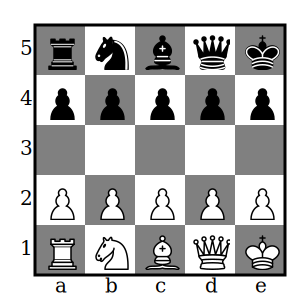

2364

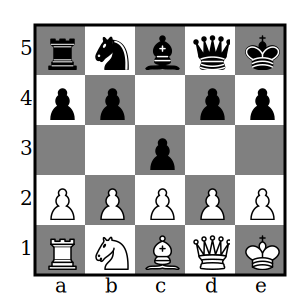

1825

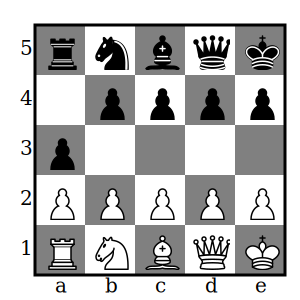

1687

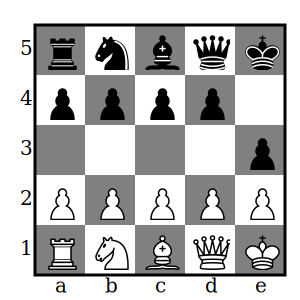

1671

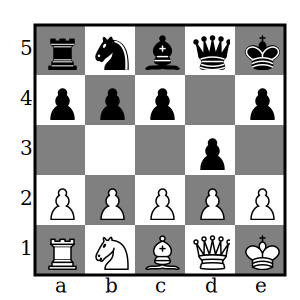

1639

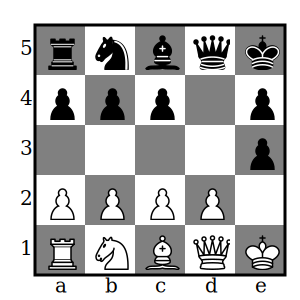

1564

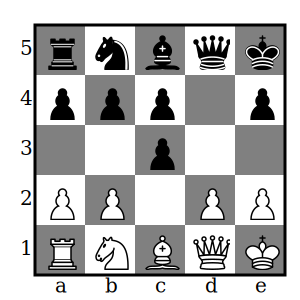

1500

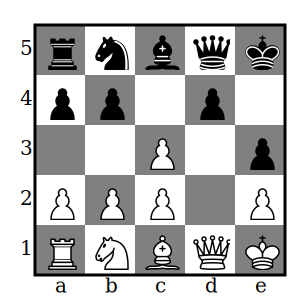

1464

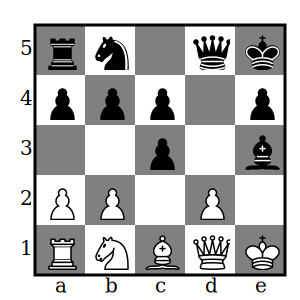

675

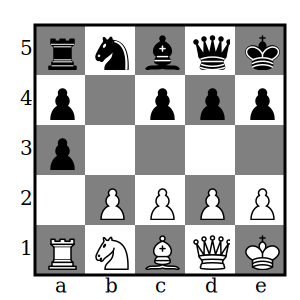

In [99]:
from rich.pretty import pprint
from IPython.display import display_svg  # type:ignore

def print_board(board):
    state = env.init(jax.random.PRNGKey(0))
    display_svg(
        state.replace(_board=board)._repr_html_(),
        raw=True,
    )

for board, cnt in boards_cnt.most_common(10):
    pprint(cnt)
    # pprint(jnp.array(board).reshape((5, 5)).transpose()[::-1])
    print_board(jnp.array(board))

In [101]:
len([cnt for _, cnt in boards_cnt.most_common()])

177504

In [65]:
a = set(map(tuple, [[1, 0], [0, 1], [1, 0], [0, 1, 0]]))
a

{(0, 1), (0, 1, 0), (1, 0)}

In [8]:
%%time

rng_key, subkey1 = jax.random.split(rng_key)
rng_key, subkey2 = jax.random.split(rng_key)
keys1 = jax.random.split(subkey1, num_devices)
keys2 = jax.random.split(subkey2, num_devices)
R1, games1 = evaluate_mcts(keys1, params_par, batch_stats_par, True)
R2, games2 = evaluate_mcts(keys2, params_par, batch_stats_par, False)
R = jnp.concatenate([R1, R2]).reshape((-1,))

avg_R = R.mean().item()
avg_R

CPU times: user 11min 19s, sys: 3.77 s, total: 11min 23s
Wall time: 3min 2s


-0.8715686798095703

In [14]:
state = init_fn(rng_key[None])
state

State(current_player=Array([0], dtype=int32), observation=Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32), rewards=Array([[0., 0.]], dtype=float32), terminated=Array([False], dtype=bool), truncated=Array([False], dtype=bool), legal_action_mask=Array([[False, False, False, ..., False, False, False]], dtype=bool), _step_count=Array([0], dtype=int32), _turn=Array([0], dtype=int32), _board=Array([[ 4,  1,  0, -1, -4,  2,  1,  0, -1, -2,  3,  1,  0, -1, -3,  5,
         1,  0, -1, -5,  6,  1,  0, -1, -6]], dtype=int32), _halfmove_count=Array([0], dtype=int32), _fullmove_count=Array([1], dtype=int32), _zobrist_hash=Array([[2025569903, 1172890342]], dtype=uint32), _hash_history=Array([[[2025569903, 1172890342],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          0],
        [         0,          

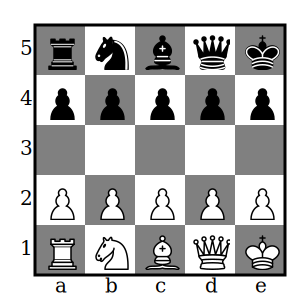

In [91]:

display_svg(
    state._repr_html_(),
    raw=True,
)

In [25]:
def predict_root(state: pgx.State) -> Tuple[jnp.ndarray, jnp.ndarray]:
    if config['use_gnn']:
        x = state_to_graph(state._board, state.observation, state.legal_action_mask) # type: ignore
    else:
        x = state.observation
    (logits, value), _ = model.apply(
        {'params': params, 'batch_stats': batch_stats},
        x,
        mutable=['batch_stats'],
        training=False
    )
    logits = logits.reshape((1, -1))
    value = value.reshape((1,)) # type: ignore

    return logits, value

logits, value = predict_root(state)
logits, value

(Array([[-1633.6129, -1633.6129, -1633.6129, ..., -1633.6129, -1633.6129,
         -1633.6129]], dtype=float32),
 Array([0.01176648], dtype=float32))

In [48]:
def get_policy(
    state: pgx.State,
    logits: jnp.ndarray,
    value: jnp.ndarray,
    keys: jnp.ndarray,
):
    root = mctx.RootFnOutput(prior_logits=logits, value=value, embedding=state) # type: ignore
    policy_output = mctx.gumbel_muzero_policy(
        params={'params': params, 'batch_stats': batch_stats},
        rng_key=keys,
        root=root,
        recurrent_fn=recurrent_fn,
        num_simulations=config['num_simulations'],
        invalid_actions=~state.legal_action_mask,
        qtransform=mctx.qtransform_completed_by_mix_value,
        gumbel_scale=1.0,
    )
    return policy_output

policy = get_policy(state, *predict_root(state), jax.random.split(rng_key)[0])
policy

PolicyOutput(action=Array([62], dtype=int32), action_weights=Array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32), search_tree=Tree(node_visits=Array([[33, 12, 12,  4,  1,  1,  1,  1,  5,  4,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1]], dtype=int32), raw_values=Array([[0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648, 0.01176648, 0.01176648,
        0.01176648, 0.01176648, 0.01176648]], dtype=float32), node_values=Array([[ 0.0017828 , -0.00196108, -0.00392216, -0.00588324,  0.01176648,
         0.01176648,  0.01176648,  0.01176648, -0.00705989, -0.00588324,
         0.01176648,  0.01176648,  0.0117664

In [51]:
policy.action_weights[state.legal_action_mask], policy.action, logits[0, policy.action[0]]

(Array([2.3632887e-01, 6.0432393e-04, 1.2312259e-01, 6.3593739e-01,
        9.4636757e-04, 1.6853740e-03, 1.3750750e-03], dtype=float32),
 Array([62], dtype=int32),
 Array(1.2804415, dtype=float32))

In [44]:
policy.action_weights[state.legal_action_mask]

Array([0.00197447, 0.07793329, 0.00051635, 0.00134072, 0.48397446,
       0.43283308, 0.00142776], dtype=float32)

In [27]:
logits.max()

Array(1.2804415, dtype=float32)

In [34]:
logits[:, state.legal_action_mask[0]]

Array([[ 1.2804415 ,  0.13381696, -0.06054866,  0.89257205,  0.58231807,
         1.1591891 ,  0.95579493]], dtype=float32)

In [35]:
logits[0, policy.action[0]]

Array(0.13381696, dtype=float32)

In [37]:
def move_pgn(move, i=0, board=None, brackets=False):
    if board is None:
        board = [
            ['R','N','B','Q','K'],
            ['P','P','P','P','P'],
            [' ',' ',' ',' ',' '],
            ['P','P','P','P','P'],
            ['R','N','B','Q','K']
        ]

    moves_from, moves_plane = move // 49, move % 49
    moves_to = pgc.TO_MAP[moves_from, moves_plane]
    moves_underpromotion = moves_plane // 3 if moves_plane < 9 else -1
    def square2cart(square):
        row, col = square % 5, square // 5
        if i % 2 == 1:
            row = 4 - row
        return row, col
    def square2str(square):
        row, col = square2cart(square)
        return chr(ord('a') + col) + str(row + 1)
    from_row, from_col = square2cart(moves_from)
    to_row, to_col = square2cart(moves_to)
    piece = board[from_row][from_col]
    promotion = piece == "P" and to_row == (4 if i % 2 == 0 else 0)
    new_piece = piece
    if promotion:
        new_piece = "QRBN"[1+moves_underpromotion]
    board[to_row][to_col] = new_piece
    board[from_row][from_col] = ' '
    return (
          ("" if i % 2 == 1 else str(i // 2 + 1) + ". ")
        + ("(" if brackets else "")
        + ("" if piece in " P" else piece)
        + square2str(moves_from)
        + square2str(moves_to)
        + ("" if not promotion else "=" + "QRBN"[1+moves_underpromotion])
        + (")" if brackets else "")
    )

move_pgn(policy.action[0])

'1. Nb1a3'

In [38]:
import jax.numpy as jnp
state.legal_action_mask[0].nonzero()

(Array([  62,  289,  293,  307,  552,  797, 1042], dtype=int32),)

In [42]:
[move_pgn(x) for x in state.legal_action_mask[0].nonzero()[0]]

['1. a2a3', '1. Nb1a3', '1. Nb1c3', '1. b2b3', '1. c2c3', '1. d2d3', '1. e2e3']

In [ ]:
def gumbel_muzero_policy(
    params: base.Params,
    rng_key: chex.PRNGKey,
    root: base.RootFnOutput,
    recurrent_fn: base.RecurrentFn,
    num_simulations: int,
    invalid_actions: Optional[chex.Array] = None,
    max_depth: Optional[int] = None,
    loop_fn: base.LoopFn = jax.lax.fori_loop,
    *,
    qtransform: base.QTransform = qtransforms.qtransform_completed_by_mix_value,
    max_num_considered_actions: int = 16,
    gumbel_scale: chex.Numeric = 1.,
) -> base.PolicyOutput[action_selection.GumbelMuZeroExtraData]:
  """Runs Gumbel MuZero search and returns the `PolicyOutput`.

  This policy implements Full Gumbel MuZero from
  "Policy improvement by planning with Gumbel".
  https://openreview.net/forum?id=bERaNdoegnO

  At the root of the search tree, actions are selected by Sequential Halving
  with Gumbel. At non-root nodes (aka interior nodes), actions are selected by
  the Full Gumbel MuZero deterministic action selection.

  In the shape descriptions, `B` denotes the batch dimension.

  Args:
    params: params to be forwarded to root and recurrent functions.
    rng_key: random number generator state, the key is consumed.
    root: a `(prior_logits, value, embedding)` `RootFnOutput`. The
      `prior_logits` are from a policy network. The shapes are
      `([B, num_actions], [B], [B, ...])`, respectively.
    recurrent_fn: a callable to be called on the leaf nodes and unvisited
      actions retrieved by the simulation step, which takes as args
      `(params, rng_key, action, embedding)` and returns a `RecurrentFnOutput`
      and the new state embedding. The `rng_key` argument is consumed.
    num_simulations: the number of simulations.
    invalid_actions: a mask with invalid actions. Invalid actions
      have ones, valid actions have zeros in the mask. Shape `[B, num_actions]`.
    max_depth: maximum search tree depth allowed during simulation.
    loop_fn: Function used to run the simulations. It may be required to pass
      hk.fori_loop if using this function inside a Haiku module.
    qtransform: function to obtain completed Q-values for a node.
    max_num_considered_actions: the maximum number of actions expanded at the
      root node. A smaller number of actions will be expanded if the number of
      valid actions is smaller.
    gumbel_scale: scale for the Gumbel noise. Evalution on perfect-information
      games can use gumbel_scale=0.0.

  Returns:
    `PolicyOutput` containing the proposed action, action_weights and the used
    search tree.
  """
  # Masking invalid actions.
  root = root.replace(
      prior_logits=_mask_invalid_actions(root.prior_logits, invalid_actions))

  # Generating Gumbel.
  rng_key, gumbel_rng = jax.random.split(rng_key)
  gumbel = gumbel_scale * jax.random.gumbel(
      gumbel_rng, shape=root.prior_logits.shape, dtype=root.prior_logits.dtype)

  # Searching.
  extra_data = action_selection.GumbelMuZeroExtraData(root_gumbel=gumbel)
  search_tree = search.search(
      params=params,
      rng_key=rng_key,
      root=root,
      recurrent_fn=recurrent_fn,
      root_action_selection_fn=functools.partial(
          action_selection.gumbel_muzero_root_action_selection,
          num_simulations=num_simulations,
          max_num_considered_actions=max_num_considered_actions,
          qtransform=qtransform,
      ),
      interior_action_selection_fn=functools.partial(
          action_selection.gumbel_muzero_interior_action_selection,
          qtransform=qtransform,
      ),
      num_simulations=num_simulations,
      max_depth=max_depth,
      invalid_actions=invalid_actions,
      extra_data=extra_data,
      loop_fn=loop_fn)
  summary = search_tree.summary()

  # Acting with the best action from the most visited actions.
  # The "best" action has the highest `gumbel + logits + q`.
  # Inside the minibatch, the considered_visit can be different on states with
  # a smaller number of valid actions.
  considered_visit = jnp.max(summary.visit_counts, axis=-1, keepdims=True)
  # The completed_qvalues include imputed values for unvisited actions.
  completed_qvalues = jax.vmap(qtransform, in_axes=[0, None])(  # pytype: disable=wrong-arg-types  # numpy-scalars  # pylint: disable=line-too-long
      search_tree, search_tree.ROOT_INDEX)
  to_argmax = seq_halving.score_considered(
      considered_visit, gumbel, root.prior_logits, completed_qvalues,
      summary.visit_counts)
  action = action_selection.masked_argmax(to_argmax, invalid_actions)

  # Producing action_weights usable to train the policy network.
  completed_search_logits = _mask_invalid_actions(
      root.prior_logits + completed_qvalues, invalid_actions)
  action_weights = jax.nn.softmax(completed_search_logits)
  return base.PolicyOutput(
      action=action,
      action_weights=action_weights,
      search_tree=search_tree)

# Retrain using 305 data

In [102]:
dummy_state = init_fn(jax.random.split(jax.random.PRNGKey(0), 2))
x = state_to_graph(dummy_state._board, dummy_state.observation, dummy_state.legal_action_mask)

variables = model.init(jax.random.PRNGKey(0), x)
params_new, batch_stats_new = variables['params'], variables['batch_stats']

In [116]:
opt_state_new = optimizer.init(params=params_new)
(params_nd, batch_stats_nd, opt_state_nd) = \
    jax.device_put_replicated((params_new, batch_stats_new, opt_state_new), devices)

In [104]:
samples_flat = jax.tree_util.tree_map(lambda x: x.reshape((-1, *x.shape[3:])), samples)

Output()

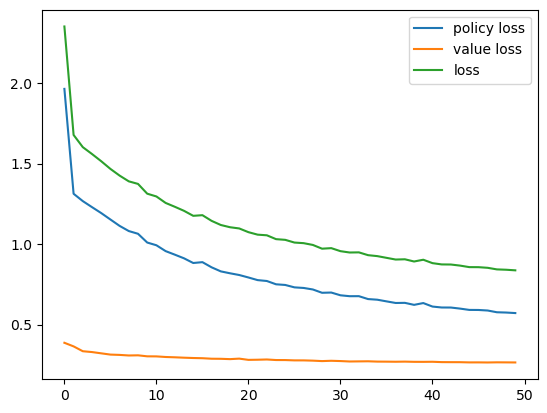

In [114]:
import rich.progress as rp

# Training step
ov_policy_losses, ov_value_losses = [], []
n_iter = 50
with rp.Progress(
    *rp.Progress.get_default_columns(),
    rp.TimeElapsedColumn(),
    rp.MofNCompleteColumn(),
    rp.TextColumn("{task.fields[logs]}"),
) as progress:
    task = progress.add_task(
        "[green]Training",
        total=n_iter,
        logs='...',
    )
    for _ in range(n_iter):
        policy_losses, value_losses = [], []

        # Shuffle samples and make minibatches
        rng_key, subkey = jax.random.split(rng_key)
        ixs = jax.random.permutation(subkey, jnp.arange(cast(Sample, samples_flat).obs.shape[0]))
        samples_flat = jax.tree_map(lambda x: x[ixs], samples_flat)  # shuffle
        num_updates = samples_flat.obs.shape[0] // config['training_batch_size']
        minibatches = jax.tree_map(
            lambda x: x.reshape((num_updates, num_devices, -1) + x.shape[1:]), samples_flat
        )

        for i in range(num_updates):
            minibatch: Sample = jax.tree_map(lambda x: x[i], minibatches)
            params_nd, batch_stats_nd, opt_state_nd, policy_loss, value_loss = train(params_nd, batch_stats_nd, opt_state_nd, minibatch)
            policy_losses.append(policy_loss.mean().item())
            value_losses.append(value_loss.mean().item())
        policy_loss = sum(policy_losses) / len(policy_losses)
        value_loss = sum(value_losses) / len(value_losses)
        ov_policy_losses.append(policy_loss)
        ov_value_losses.append(value_loss)
        progress.update(task, advance=1, logs=f'{policy_loss+value_loss:.5f} = {policy_loss:.5f} + {value_loss:.5f}')

import matplotlib.pyplot as plt
plt.plot(ov_policy_losses, label="policy loss")
plt.plot(ov_value_losses, label="value loss")
plt.plot([policy + value for policy, value in zip(ov_policy_losses, ov_value_losses)], label="loss")
plt.legend()

In [115]:
%%time

rng_key, subkey1 = jax.random.split(rng_key)
rng_key, subkey2 = jax.random.split(rng_key)
keys1 = jax.random.split(subkey1, num_devices)
keys2 = jax.random.split(subkey2, num_devices)
R1, games1 = evaluate_mcts(keys1, params_nd, batch_stats_nd, True)
R2, games2 = evaluate_mcts(keys2, params_nd, batch_stats_nd, False)
R = jnp.concatenate([R1, R2]).reshape((-1,))

avg_R = R.mean().item()
avg_R

CPU times: user 11min 23s, sys: 310 ms, total: 11min 24s
Wall time: 1min 58s


-0.3127451241016388

Output()

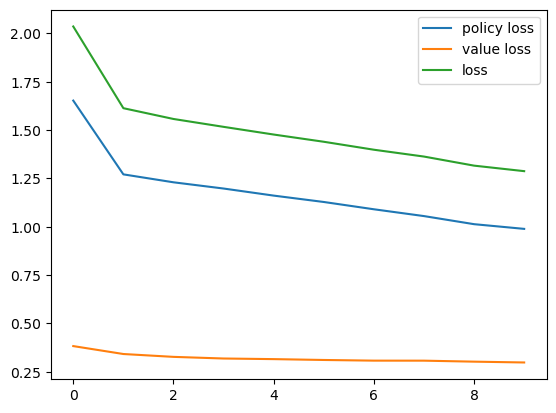

Output()

-0.5254902243614197


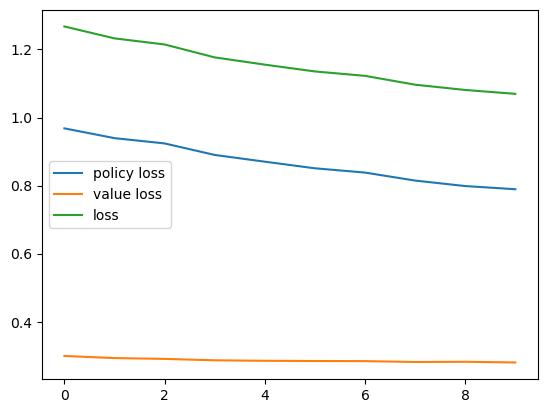

Output()

-0.2343137413263321


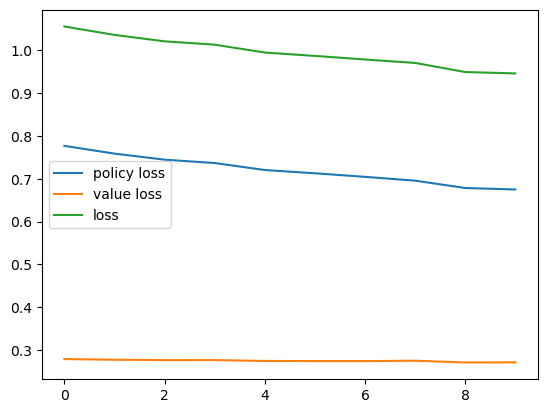

Output()

-0.4117647409439087


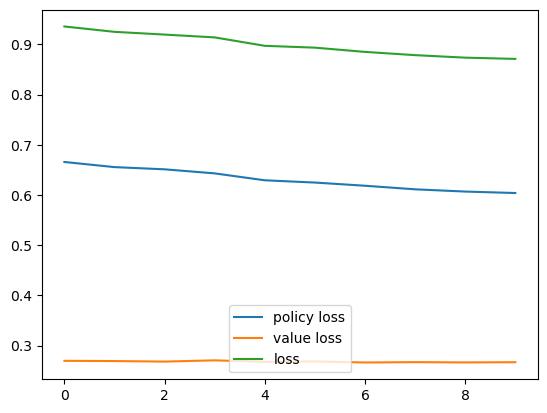

Output()

-0.37843140959739685


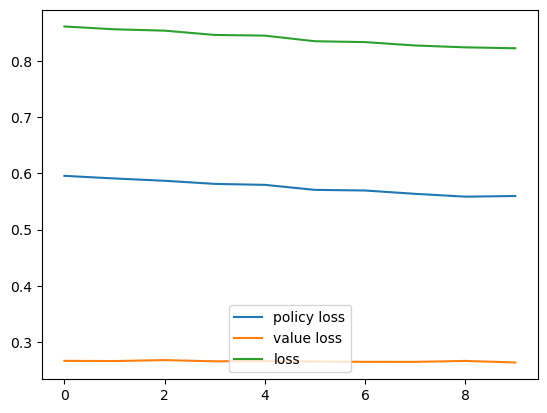

Output()

-0.3558823764324188


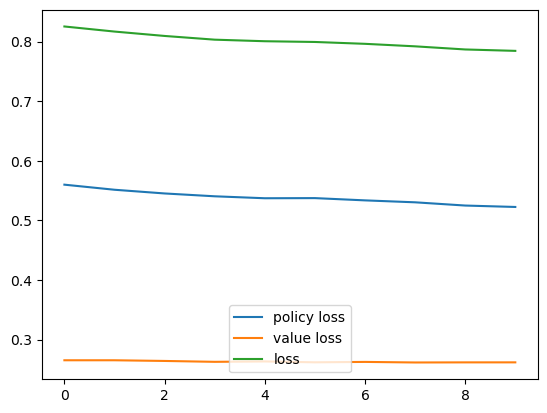

Output()

-0.23627452552318573


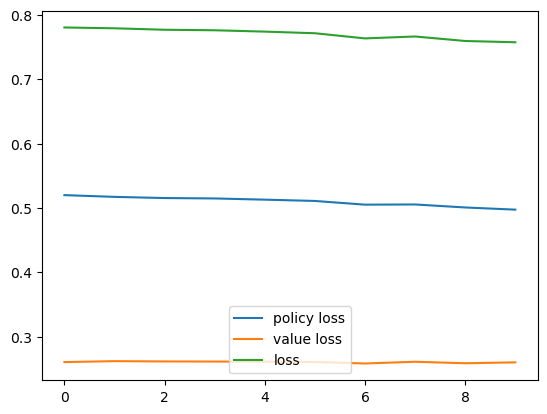

Output()

-0.32156863808631897


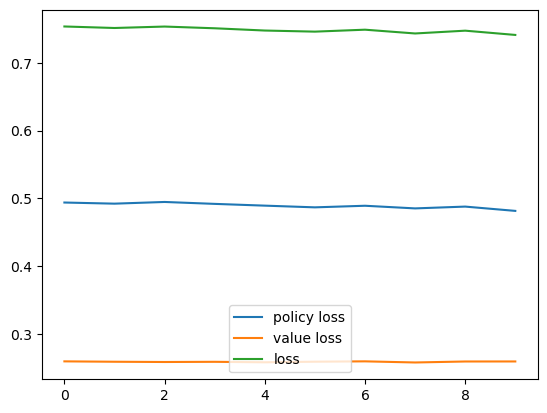

Output()

-0.4382353127002716


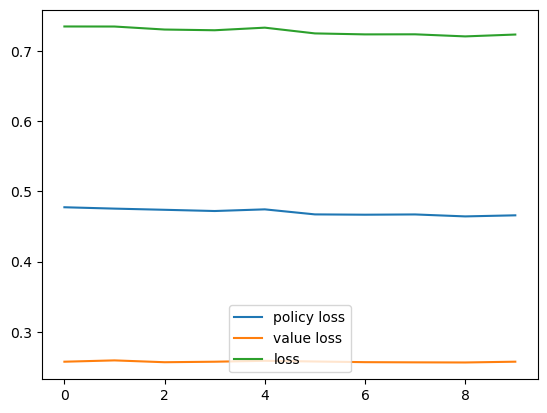

Output()

-0.3598039448261261


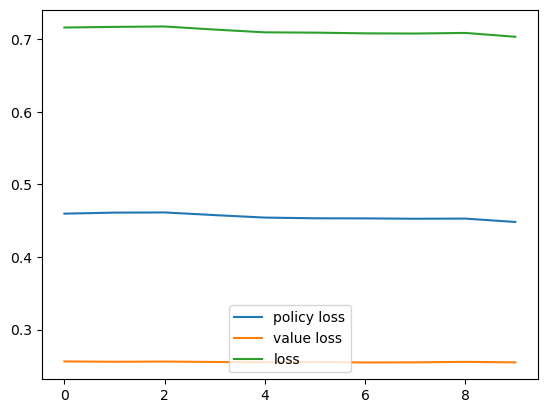

Output()

-0.28333336114883423


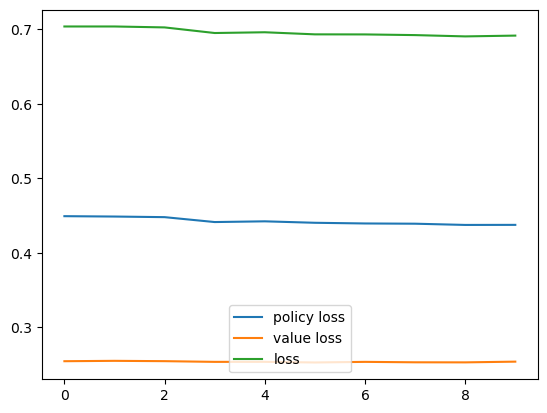

Output()

-0.3764706254005432


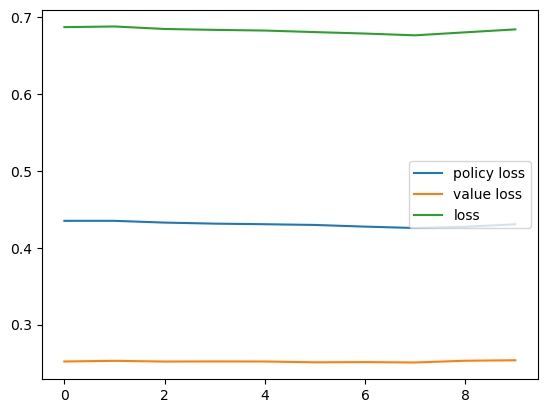

Output()

-0.33725491166114807


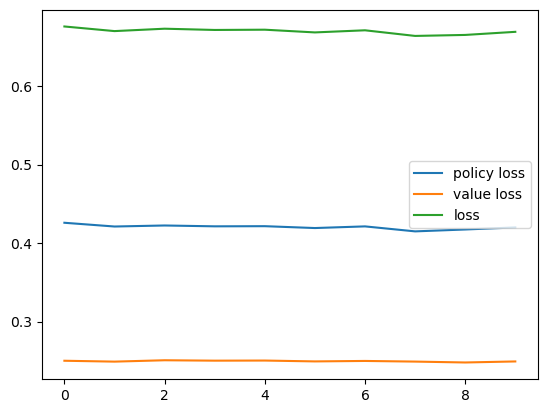

Output()

-0.3901961147785187


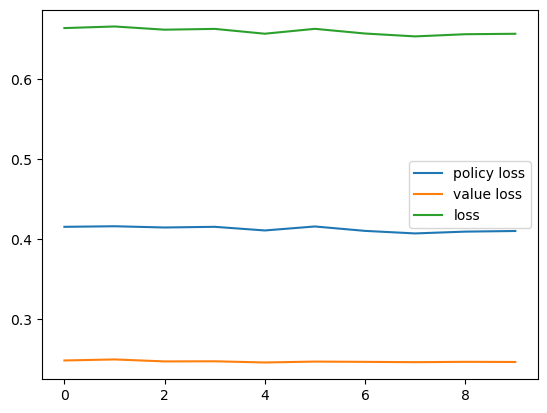

Output()

-0.480392187833786


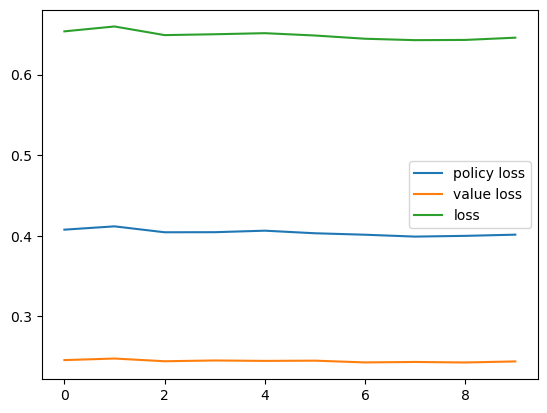

Output()

-0.44607844948768616


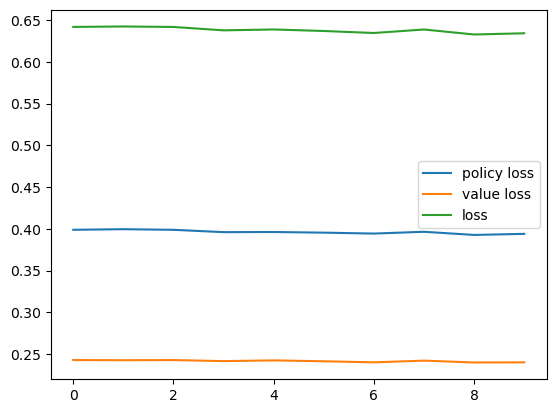

Output()

-0.3960784673690796


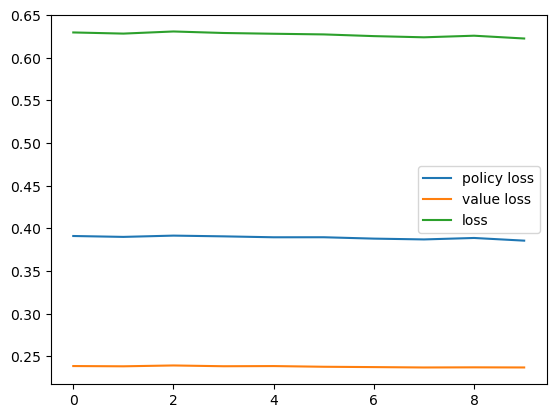

Output()

-0.3450980484485626


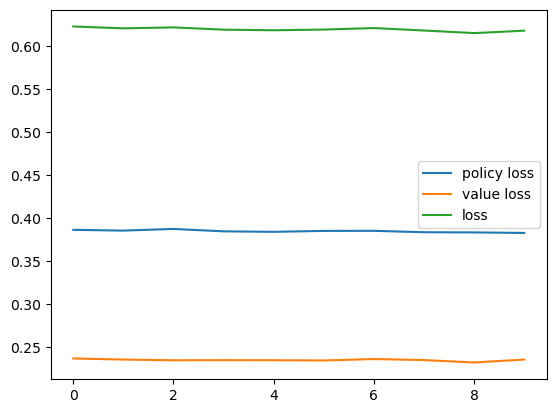

Output()

-0.3813725709915161


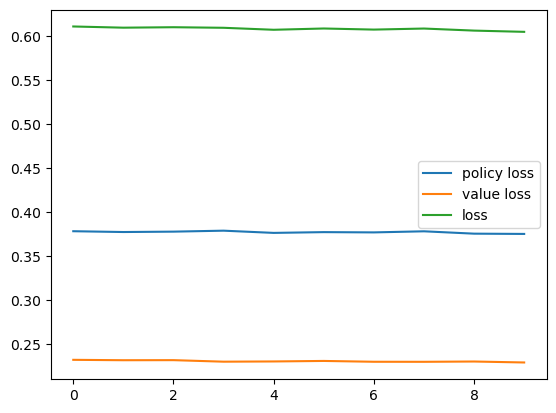

Output()

-0.479411780834198


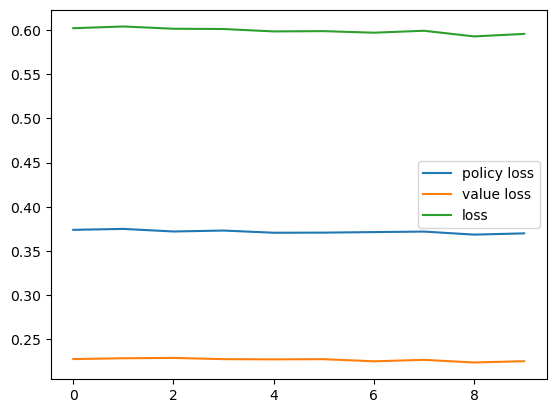

-0.529411792755127


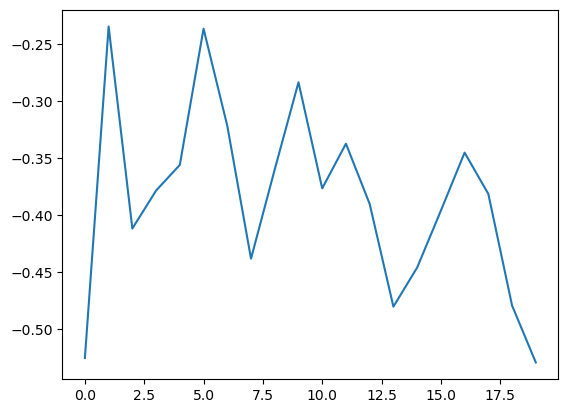

In [117]:
Rs = []
with rp.Progress(
    *rp.Progress.get_default_columns(),
    rp.TimeElapsedColumn(),
    rp.MofNCompleteColumn(),
    rp.TextColumn("{task.fields[logs]}"),
) as progress:
    task = progress.add_task(
        "[cyan]Restart",
        total=20,
        logs='...',
    )
    for _ in range(20):
        # Training step
        ov_policy_losses, ov_value_losses = [], []
        n_iter = 10
        task_training = progress.add_task(
            "[green]Training",
            total=n_iter,
            logs='...',
        )
        for _ in range(n_iter):
            policy_losses, value_losses = [], []

            # Shuffle samples and make minibatches
            rng_key, subkey = jax.random.split(rng_key)
            ixs = jax.random.permutation(subkey, jnp.arange(cast(Sample, samples_flat).obs.shape[0]))
            samples_flat = jax.tree_map(lambda x: x[ixs], samples_flat)  # shuffle
            num_updates = samples_flat.obs.shape[0] // config['training_batch_size']
            minibatches = jax.tree_map(
                lambda x: x.reshape((num_updates, num_devices, -1) + x.shape[1:]), samples_flat
            )

            for i in range(num_updates):
                minibatch: Sample = jax.tree_map(lambda x: x[i], minibatches)
                params_nd, batch_stats_nd, opt_state_nd, policy_loss, value_loss = train(params_nd, batch_stats_nd, opt_state_nd, minibatch)
                policy_losses.append(policy_loss.mean().item())
                value_losses.append(value_loss.mean().item())
            policy_loss = sum(policy_losses) / len(policy_losses)
            value_loss = sum(value_losses) / len(value_losses)
            ov_policy_losses.append(policy_loss)
            ov_value_losses.append(value_loss)
            progress.update(task_training, advance=1, logs=f'{policy_loss+value_loss:.5f} = {policy_loss:.5f} + {value_loss:.5f}')

    import matplotlib.pyplot as plt
    plt.plot(ov_policy_losses, label="policy loss")
    plt.plot(ov_value_losses, label="value loss")
    plt.plot([policy + value for policy, value in zip(ov_policy_losses, ov_value_losses)], label="loss")
    plt.legend()
    plt.show()
    
    rng_key, subkey1 = jax.random.split(rng_key)
    rng_key, subkey2 = jax.random.split(rng_key)
    keys1 = jax.random.split(subkey1, num_devices)
    keys2 = jax.random.split(subkey2, num_devices)
    R1, games1 = evaluate_mcts(keys1, params_nd, batch_stats_nd, True)
    R2, games2 = evaluate_mcts(keys2, params_nd, batch_stats_nd, False)
    R = jnp.concatenate([R1, R2]).reshape((-1,))

    avg_R = R.mean().item()
    print(avg_R)
    Rs.append(avg_R)
    progress.update(task, advance=1, logs=f'{avg_R:.5f}')
plt.plot(Rs)
plt.show()